# Obsolescence des smartphones

---

Jérémie GANTET INSA Informatique & Réseaux 😏 <br>
24 juillet 2020

---

### Librairies

In [3]:
"""
@author: Jérémie GANTET (usernamedjpris) INSA Toulouse
"""
# dates/utils
import datetime
from datetime import date
import pandas as pd
import math
import copy
# scipy
import scipy.stats as stat
from scipy.stats import norm
from scipy.stats import alpha
from scipy.stats import lognorm
from scipy.stats import exponweib
from scipy.optimize import minimize
from scipy.stats import weibull_min
from scipy.stats import triang
from scipy.stats import tvar
from scipy.stats import tstd
# sklearn
from sklearn import dummy
from sklearn import neighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# beautiful print/plot
from sty import fg, bg, ef, rs
import seaborn as sns
%pylab inline
sns.set()
pd.options.mode.chained_assignment = None 
# jupyter GUI
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
from IPython.display import display
%config InlineBackend.close_figures=False 

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jérémie\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Importation des fichiers par marque de smartphone
- dates de début commercialisation 
- nombres de ventes par trimestre

In [4]:
dates = pd.read_csv('E:/eDocuments/obso/dates.csv', sep=';')
ventes = pd.read_csv('E:/eDocuments/obso/vente_tout_constructeurs.csv', sep=';')
medianes = dates.groupby(["marque"]).median()
diff = dates["différence"]

# remplissage median des différences allons-y franchement quoi
for i,diff in enumerate(dates["différence"]):
    if diff != diff: # NaN test
        dates["différence"][i] = medianes["différence"][dates["marque"][i]]

# formatage des données    
for i,debut in enumerate(dates["date"]):
    if not(isinstance(debut, datetime.date)): 
        if debut != debut:
            continue
        if debut.find("/")<0:
            continue
        dates["date"][i] = datetime.date(int(debut.split("/")[2]),int(debut.split("/")[1]),int(debut.split("/")[0]))
    if dates["date_fin"][i] != dates["date_fin"][i]: # NaN test
        #dates["date_fin"][i] = dates["date"][i] + datetime.date(int(medianes["différence"][dates["marque"][i]]//12),int(medianes["différence"][dates["marque"][i]]%12+1),int((medianes["différence"][dates["marque"][i]]%int(medianes["différence"][dates["marque"][i]]))*60+1))
        dates["date_fin"][i] = dates["date"][i] + datetime.timedelta(days=medianes["différence"][dates["marque"][i]]*30)
    if not(isinstance(dates["date_fin"][i], datetime.date)):
        if dates["date_fin"][i].find("/")<0:
            continue
        dates["date_fin"][i] = datetime.date(int(dates["date_fin"][i].split("/")[2]),int(dates["date_fin"][i].split("/")[1]),int(dates["date_fin"][i].split("/")[0]))

# catégorisation par marque des dates de début, de fin et des noms des modèles
touteslesmarques = ["Apple", "Samsung", "OnePlus", "Xiaomi", "Oppo", "Vivo", "Sony", "Huawei", "Google", "Motorola"]
for marque in touteslesmarques:
    globals()["debut_"+marque] = []
    globals()["fin_"+marque] = []
    globals()["modele_"+marque] = []
    for i,d in enumerate(dates["date"]):
        if dates["marque"][i] == marque:
            globals()["debut_"+marque].append(d)
            globals()["fin_"+marque].append(dates["date_fin"][i])
            globals()["modele_"+marque].append(dates["modèle"][i])
            
# axe des x : temps discrétisé en trimestre 
trimestre = [datetime.date(int(d.split("/")[2]),int(d.split("/")[1]),int(d.split("/")[0])).toordinal() for d in ventes["Trimestre"]]
limites = [date.fromordinal(trimestre[0]),date.fromordinal(trimestre[-1])]

data = pd.read_csv('E:/eDocuments/obsolescence_prediction/data.csv', sep=';')

### Code modèles de distribution

In [6]:
ladistribution = 'alpha'
nb_sample = 1
leseuil = 80 #%
ax = plt.gca()
# fonction de distribution
def distrib(x,debut,scale,var,offset):
    """modèles de distribution"""
    global ladistribution
    if ladistribution == "alpha":
        return alpha.pdf(x, 0.8, debut-scale/10, scale)*var*scale  
    elif ladistribution == "gauss":
        return stat.norm.pdf(x,debut,scale)*var*scale
    elif ladistribution == "triangle":
        return triang.pdf(x,0,debut,scale)*var*scale 
    elif ladistribution == "weibull":
        return weibull_min.pdf(x, 1.1, debut+offset, scale)*var*scale
    
def distrib_cumulated(x,scale,var):
    """modèles de distribution cumulées"""
    global ladistribution
    if ladistribution == "alpha":
        return alpha.cdf(x, 0.8, 0, scale) 
    elif ladistribution == "gauss":
        return stat.norm.cdf(x,0,scale)
    elif ladistribution == "triangle":
        return triang.cdf(x,0,0,scale)
    elif ladistribution == "weibull":
        return weibull_min.cdf(x, 1.1, 0, scale) 
    
def distrib_quantile(q,scale):
    """modèles de distribution pour partager en quantile"""
    global ladistribution
    if ladistribution == "alpha":
        return alpha.ppf(q, 0.8, 0, scale)  
    elif ladistribution == "gauss":
        return stat.norm.ppf(q,0,scale)
    elif ladistribution == "triangle":
        return triang.ppf(q,0,0,scale) 
    elif ladistribution == "weibull":
        return weibull_min.ppf(q, 1.1, 0, scale)
    
# fonctions de mises à jour    
def update_samples(b):
    flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    global nb_sample, leseuil,ax
    nb_sample = b['new']
    ax.clear()
    x = np.arange(-3, 30, 0.05)
    for i in range(b['new']):
        scale = i+0.2*10
        y = distrib(x,0,scale,1,0)
        ax.plot(x,y, color=flatui[i%len(flatui)])    
        ax.axvline(x=distrib_quantile(leseuil/100,scale),color=flatui[i%len(flatui)])        
    ax.set_xlim([-3,30])
    ax.set_title("allure de la courbe de distribution de ventes d'un modèle de smartphone pour différentes largeurs")
    with out_samples:
        clear_output(wait=True)
        display(ax.figure)

def update_seuil(b):
    global leseuil,nb_sample
    leseuil = b['new']
    update_samples({'new':nb_sample})
    
def change_distrib(b):
    global ladistribution,nb_sample
    ladistribution = b['new']
    update_samples({'new':nb_sample})
    
# fonction principale d'affichage 
def show_samples():
    globals()["out_samples"] = widgets.Output(layout=Layout(height='400px', width = '1000px'))
    globals()["int_range"] = widgets.IntSlider(value=1, description="Aperçus", max=25)
    globals()["seuil_range"] = widgets.IntSlider(value=80, description="seuil (%)", max=99)
    globals()["d"] = widgets.Dropdown(options=['alpha', 'weibull', 'triangle', 'gauss']) 
    global ax
    plt.ioff()
    fig, ax = subplots(figsize=(11,6))
    #ax=plt.gca()
    display(d)
    display(seuil_range)
    display(int_range, out_samples)
    seuil_range.observe(update_seuil, names='value')
    int_range.observe(update_samples, names='value')
    d.observe(change_distrib, names='value')
    change_distrib({'new':'alpha'})
    update_seuil({'new':80})   
    update_samples({'new':1})   


### Code optimisation

In [7]:
lamarque = ['Apple']
methode = 'Powell'
renverse = False
lanorme = "norme 1"
minX, maxX = 60, 270
minY, maxY = 50000,60000000
offsetM, offsetP= -60, 180

def mini_obj(X, args, ventes_totales, abscisses):
    #print(X)
    cumul = [0 for i in range(len(abscisses))]
    for i in range(int(len(X)/3)):
        largeur, hauteur, offset = X[i*3], X[i*3+1], X[i*3+2]
        date, ponderation = args[i*2], args[i*2+1]
        y=distrib(abscisses, date, largeur, hauteur, offset)
        cumul = [cumul[i]+x for i,x in enumerate(y)]    #*ponderation for i,x in enumerate(y)]             
    return cumul

def montre_solution(X, args, ventes_totales, abscisses, agregat_modeles):
    global limites, leseuil
    cumul = [0 for i in range(len(abscisses))]
    fig, ax = plt.subplots(figsize=(12,6))
    for i in range(int(len(X)/3)):
        largeur, hauteur, offset = X[i*3], X[i*3+1], X[i*3+2]
        date, ponderation = args[i*2], args[i*2+1]
        y=distrib(abscisses, date, largeur, hauteur, offset)
        cumul = [cumul[i]+x for i,x in enumerate(y)]    #*ponderation for i,x in enumerate(y)]           
        ax.plot(abscisses, y, label=agregat_modeles[i]+"\nlargeur : "+str(round(largeur,1))+" hauteur : "+str(round(hauteur,1)))    #distrib_quantile(leseuil/100,largeur),1))+" hauteur : "+str(round(hauteur,1)))    
    ax.plot(abscisses, cumul, 'k', label="ventes cumulees")
    ax.plot(abscisses, ventes_totales, 'b', label="ventes totales")
    ax.legend(bbox_to_anchor=(1.5, 1))
    ax.set_xlim(limites)
    plt.show()

def objectif(X, args, ventes_totales, abscisses):
    global lanorme
    ventes_cumulees = mini_obj(X, args, ventes_totales, abscisses)
    if lanorme == "norme 1":
        result = float(abs(sum([abs(x-y) for x,y in zip(ventes_cumulees, ventes_totales)])))
    elif lanorme == "norme 2":
        result = float(np.sqrt(sum([(x-y)**2 for x,y in zip(ventes_cumulees, ventes_totales)])))
    #print(result)
    return result

def obj(X):
    global dates, args, trimestre, ventes_totales 
    return objectif(X, args, [v for v in ventes_totales], [t for t in trimestre])

def choose_brand(marque):
    global lamarque
    if marque == "Apple":
        lamarque = ['Apple']
    elif marque == "Samsung":
        lamarque = ['Samsung']  
    elif marque == "Xiaomi":
        lamarque = ['Xiaomi'] 
    elif marque == "Oppo":
        lamarque = ['Oppo'] 
    elif marque == "Vivo":
        lamarque = ['Vivo']
    elif marque == "Sony":
        lamarque = ['Sony']
    elif marque == "Huawei":
        lamarque = ['Huawei']
    elif marque == "Toutes":
        lamarque = ["Apple", "Samsung", "Xiaomi", "Oppo", "Vivo", "Sony", "Huawei"]

def optimiseur():
    globals()['args'] = []
    global renverse, methode, lamarque, args, ladistribution, ventes_totales, lanorme, offsetP, offsetM, minX, maxX, minY, maxY
    plt.close('all')
    for marque in lamarque:
        
        agregat_modeles = dates.loc[lambda df: dates['marque'] == marque, :].groupby('date').apply(lambda x: ', '.join(x.modèle))
        ventes_totales = [0 if v != v else float(v.replace(",","."))*1000000  for v in ventes[marque]]
        df_args =  dates.loc[lambda df: dates['marque'] == marque, :].groupby('date').count()["marque"]
        x1 = []
        bnds = ()
        for date in df_args.index:        
            if isinstance(date, datetime.date):
                if not renverse:                    
                    args.append(date.toordinal())
                    args.append(df_args[date])
                    x1 = x1+[60,1000000,0]
                else:
                    args.append(df_args[date])
                    args.append(date.toordinal())
                    x1 = x1+[0,1000000,60]                                        
                bnds = bnds + ((minX, maxX*1.138591143459572),(minY, maxY),(offsetM,offsetP),)#(500000/df_args[date], 60000000/df_args[date]),)
        if renverse:
            args = args[::-1]
            x1 = x1[::-1]

        result = minimize(obj, x1, method = methode, bounds=bnds)
        montre_solution(result.x, args, ventes_totales, trimestre, agregat_modeles)
        chronooupaschrono = "chrono" if not renverse else "antichrono"
        params = "["+ladistribution+", "+methode+", "+marque+", "+chronooupaschrono+"]"
        params += " "*(37-len(params))+" X("+str(minX)+", "+str(maxX)+")"+ " Y("+str(minY)+", "+str(maxY)+")"+ " Offset("+str(offsetM)+", "+str(offsetP)+")" 
        objectif = str(int(obj(result.x)))
        ligne_resultat = params+" "*(87-len(params))+" écart "+lanorme+" "*(11-len(objectif))+bg.red+fg.white+" "+objectif+" "+fg.rs+bg.rs
        return ligne_resultat
        #for i in range(int(len(result.x)/3)):
        #    for modele in agregat_modeles[i].split(", "):
        #        print(modele+";"+str(result.x[i*3]).replace(".",","))
        
# fonction principale d'affichage 
def optimisation():
    globals()["button1"] = widgets.Button(description="Lancer optimisation")
    globals()["out_optimizer"] = widgets.Output()
    globals()["out_historique"] = widgets.Output()    
    globals()["button2"] = widgets.Button(description="Renverser chrono")
    globals()["out_renverse"] = widgets.Output()
    globals()["d_methode"] = widgets.Dropdown(options=['Powell', 'L-BFGS-B', 'TNC', 'SLSQP']) 
    globals()["d_norme"] = widgets.Dropdown(options=['norme 1', 'norme 2']) 
    globals()["d_brand"] = widgets.Dropdown(options=["Apple", "Samsung", "Xiaomi", "Oppo", "Vivo", "Sony", "Huawei",'Toutes']) 
    globals()["minX_range"] = widgets.IntSlider(value=60, description="min X (jours)", min=30 , max=180)
    globals()["maxX_range"] = widgets.IntSlider(value=270, description="max X (jours)", min=30 , max=1460)
    globals()["minY_range"] = widgets.IntSlider(value=50000, description="min Y (ventes)", min=10000 , max=100000)
    globals()["maxY_range"] = widgets.IntSlider(value=60000000, description="max Y (ventes)", min=100000, max=100000000)
    globals()["offsetM_range"] = widgets.IntSlider(value=-60, description="Offset- (jours)", min=-270 , max=0)
    globals()["offsetP_range"] = widgets.IntSlider(value=180, description="Offset+ (jours)", min=0, max=270)
    plt.ioff()
    ax=plt.gca()
    
    display(d_methode)
    display(d_brand)
    display(d_norme)
    display(button2, out_renverse)
    display(minX_range,maxX_range,minY_range,maxY_range,offsetM_range,offsetP_range)
    display(button1, out_optimizer, out_historique) 
    
    button1.on_click(on_button1_clicked)
    button2.on_click(on_button2_clicked)
    d_methode.observe(change_method, names='value')
    d_brand.observe(change_brand, names='value')
    d_norme.observe(change_norme, names='value')
    minX_range.observe(change_minX, names='value')
    maxX_range.observe(change_maxX, names='value')
    minY_range.observe(change_minY, names='value')
    maxY_range.observe(change_maxY, names='value')    
    offsetM_range.observe(change_offsetM, names='value')
    offsetP_range.observe(change_offsetP, names='value') 
    
def on_button1_clicked(b):
    with out_optimizer:
        clear_output(wait=True) #pour afficher l'historique des graphes commenter cette ligne
        string = optimiseur()
    with out_historique:
        print(string)
        
def on_button2_clicked(b):
    global renverse
    renverse = not renverse    
    with out_renverse:
        clear_output(wait=True)
        print("les modèles sont dans l'ordre",("ANTI-" if renverse else "")+"chronologique")

def change_norme(b):
    global lanorme 
    lanorme = b['new']
        
def change_method(b):
    global methode 
    methode = b['new']
    
def change_minX(b):
    global minX 
    minX = b['new']
def change_maxX(b):
    global maxX 
    maxX = b['new']
def change_minY(b):
    global minY 
    minY = b['new']
def change_maxY(b):
    global maxY 
    maxY = b['new']
def change_offsetM(b):
    global offsetM 
    offsetM = b['new']
def change_offsetP(b):
    global offsetP 
    offsetP = b['new']
    
def change_brand(b):
    global brand 
    choose_brand(b['new'])

### Code machine learning

In [89]:
data = pd.read_csv('E:/eDocuments/obsolescence_prediction/data.csv', sep=';')
obso = ['obso ventes totales','obso trends']
#Formattage des données
tronq_data = data.drop(columns=['date fin commercialisation (déduite)', 'différence', 'prédécesseur',
       'successeur', 'type écran', 'certificat de résistance','nombre avis'])
tronq_data = tronq_data.drop(columns=['dxomark','Ouverture capteur selfie (ƒ/)','Ouverture capteur principal (ƒ/)', 'endurance générale ','endurance pour vidéos', 'endurance pour appeler', 'endurance pour surfer']) #265,160,45

data_float = tronq_data.copy()
for k in data_float.keys():
    if k not in ['marque', 'modèle']:
        if k not in ['résistant aux rayures', 'gorilla glass','extensible','fingerprint', 'proximité',
       'accéléromètre', "lumière d'ambiance", 'Boussole', 'gyroscope','baromètre', 'NFC', 'jack', 'radio FM', 
       'computer sync', 'tethering', 'VoLTE', 'OTA','date début commercialisation']:
            data_float[k] = [float(val.replace(",",".")) if isinstance(val, str) else val for val in data_float[k]]
        else:
            for i in range(len(data_float[k])):
                if k == "date début commercialisation":
                    if data_float[k][i] == data_float[k][i]:
                        liste_date = data_float[k][i].split('/')
                        if len(liste_date)==3:
                            data_float[k][i] = datetime.date(int(liste_date[2]),int(liste_date[1]),int(liste_date[0]))
                        else:
                            data_float[k][i] = None
                else:                        
                    if data_float[k][i] != data_float[k][i]: 
                        data_float[k][i] = 0
                    elif data_float[k][i].find("N/A")+data_float[k][i].find("Non")+1>=0:
                        data_float[k][i] = 0
                    elif data_float[k][i].find("Oui")+data_float[k][i].find("NFC market dependent")+1>=0:
                        data_float[k][i] = 1

                        
#Écummage des données
data_etiquetees = data_float.loc[data_float[obso[0]] == data_float[obso[0]]]
print("[taille départ]", data_float.shape[0])
#print("étiquetage","-"+str(data_float.shape[0]-data_etiquetees.shape[0]))
data_netoyees = data_etiquetees.copy()
shape = data_etiquetees.shape[0]
for k in data_etiquetees.keys():  
    if k != obso[1]:
        data_netoyees = data_netoyees.loc[data_netoyees[k] == data_netoyees[k]]
        if k == obso[0]:
            data_netoyees = data_netoyees.loc[data_netoyees[k] > 0] 
        #print(k,"-"+str(shape-data_netoyees.shape[0]))  
        shape = data_netoyees.shape[0]
print("[taille arrivée]", data_netoyees.shape[0])

y = np.array([int(val) for val in data_netoyees[obso[0]]])

#separation aleatoire entre donnees d'entrainement et donnees de test 
#from sklearn import model_selection
#X_train, X_test, y_train, y_test = model_selection.train_test_split(data_netoyees.drop(['marque', 'modèle','date début commercialisation', 'obso ventes totales'],axis=1), y, test_size=0.3 )
#y = np.array([int(val) for val in data_netoyees['obso ventes totales']])

#Separation aleatoire entre donnees d'entrainement et donnees de test
annee_avantapres = datetime.date(2016,12,31)
train = data_netoyees.loc[data_netoyees['date début commercialisation']<=annee_avantapres]
test = data_netoyees.loc[data_netoyees['date début commercialisation']>annee_avantapres]

print("pourcentage de données d'entraînement sur données totales",round((train.shape[0]/data_netoyees.shape[0])*100,1),"%") 
X_train = train.drop([obso[0],obso[1],'modèle', 'marque','date début commercialisation'], axis=1)
X_test = test.drop([obso[0],obso[1],'modèle', 'marque','date début commercialisation'], axis=1)
y_train = np.array([int(val) for val in train[obso[0]]])
y_test = np.array([int(val) for val in test[obso[0]]])
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)



# Boîtes noires    
    
def randomDumb(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(y_test)==0:
        return "Random (naïf)"#string name
    else:    
        y_pred_random = np.random.randint(np.min(y_train), np.max(y_train), y_test.shape)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred_random)),y_pred_random

def moyDumb(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "Moyenne (naïf)"#string name
    else:  
        dum = dummy.DummyRegressor(strategy='mean')
        dum.fit(X_train, y_train)
        y_pred_dum = dum.predict(X_test)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),y_pred_dum

def medDumb(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "Médiane (naïf)"#string name
    else:  
        dum = dummy.DummyRegressor(strategy='median')
        dum.fit(X_train, y_train)
        y_pred_dum = dum.predict(X_test)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),y_pred_dum



def foret(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "forêt aléatoire"#string name
    else:
        from sklearn.ensemble import RandomForestRegressor
        foret = RandomForestRegressor()
        modele = foret.fit(X_train_std, y_train)
        y_pred_foret = modele.predict(X_test_std)
        score_foret = np.sqrt(metrics.mean_squared_error(y_test, y_pred_foret))
        return score_foret, y_pred_foret


def sgdRegressor(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "SGD"#string name
    else:
        from sklearn.linear_model import SGDRegressor 
        sgd = SGDRegressor()
        modele = sgd.fit(X_train, y_train)
        y_pred_sgd = modele.predict(X_test)
        score_sgd = np.sqrt(metrics.mean_squared_error(y_test, y_pred_sgd))
        return score_sgd, y_pred_sgd


def gradientRegressor(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "Gradient Boosting"#string name
    else:    
        from sklearn.ensemble import GradientBoostingRegressor
        grad = GradientBoostingRegressor(random_state=1, n_estimators=10)
        modele = grad.fit(X_train, y_train)
        y_pred_grad = modele.predict(X_test)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred_grad)),y_pred_grad


def mlpRegressor(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "MLP"#string name
    else:    
        from sklearn.neural_network import MLPRegressor
        mlp = MLPRegressor(max_iter=10000, solver='lbfgs')
        modele = mlp.fit(X_train, y_train)
        y_pred_mlp = modele.predict(X_test)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlp)),y_pred_mlp


def knnRegressor(X_train=[], X_test=[], y_train=[], y_test=[]):
    if len(X_train)==0:
        return "KNN-10"#string name
    else:    
        from sklearn import neighbors
        knn = neighbors.KNeighborsRegressor(n_neighbors=10)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        return np.sqrt(metrics.mean_squared_error(y_test, y_pred)), y_pred


# Affichage du benchmarking

def show_distrib(data, y_,nom_methode,option):
    """afficher proprement le vecteur y en fonction du temps avec le modèle de distribution distrib"""
    t = np.arange(datetime.date(2010,1,1).toordinal(),datetime.date(2021,1,1).toordinal(),1)
    fig, ax1 = plt.subplots(figsize=(12,3))
    for index,(i,ligne) in enumerate(data.iterrows()):
        y = distrib(t,ligne["date début commercialisation"].toordinal(),y_[index],1,0)/y_[index]
        plt.plot(t,y,option)
    ax1.set_xlim([datetime.date(2010,1,1),datetime.date(2021,1,1)])
    plt.title(nom_methode)
    
    
def pretty_print(key, value, fg, bgcolor, bgvalue): #37: white, 33: yellow, 34: blue
    """print en couleur des lignes de résultat"""
    print(bg.rs+" "*40+"\033[1;"+fg+";"+bgcolor+"m "+key+" "*(19-len(key)),bg(bgvalue),str(round(value,1))," "*(8-len(str(round(value,1)))), bg.rs)


def benchmark(liste_fonction, liste_affichage, X_train, X_test, y_train, y_test, test): 
    """propose un comparatif de la liste_fonction avec des methodes de reference"""
    lut = [202, 203, 204, 205, 206, 207, 171, 135, 99, 63, 27, 33, 39, 45, 51, 49]#50, 48, 47, 46]
    colorbar = ""
    plt.close('all')
    for l in lut:
        colorbar += bg(l)+"  "+bg.rs
    lut.reverse()
    defaut_debiles = [randomDumb, moyDumb, medDumb]
    defaut_intelligentes = [foret,sgdRegressor,gradientRegressor,mlpRegressor]
    valeur_bg = {} 
    valeur_brute = {}
    y_resultat = {}
    for f in defaut_debiles+defaut_intelligentes+liste_fonction:
        valeur_brute[f()], y_resultat[f()] = f(X_train, X_test, y_train, y_test)
  
    minimum = np.min([x for x in valeur_brute.values()])
    maximum = np.max([x for x in valeur_brute.values()])
    for f in defaut_debiles+defaut_intelligentes+liste_fonction: 
        valeur_bg[f()] = lut[int((valeur_brute[f()]-minimum)/(maximum-minimum)*(len(lut)-1))]
    print(bg.rs+" "*40+"\033[5;37;40m     Root Mean Squared Error    ")      #erreur quadratique moyenne pris à la racine carrée pour avoir des jours  
    print()
    
    print(bg.rs+" "*40+"\033[5;30;44m Méthodes naïves ")    
    for f in defaut_debiles:
        pretty_print(f(), valeur_brute[f()], "30", "44", valeur_bg[f()])
    
    print()
    
    print(bg.rs+" "*40+"\033[5;30;44m Autres méthodes ")    
    for f in defaut_intelligentes:
        pretty_print(f(), valeur_brute[f()], "30", "44", valeur_bg[f()])
   
    for f in liste_fonction:        
        pretty_print(f(), valeur_brute[f()], "30", "46", valeur_bg[f()])
        
    print()
    
    print(bg.rs+" "*40+"\033[5;37;40m Statistiques Modes ")
    pretty_print("minimum", np.min(y_test), "37", "40", 235)
    pretty_print("1er quartile", np.quantile(y_test, 0.25), "37", "40", 235)
    pretty_print("moyenne", np.mean(y_test),"37", "40", 235)
    pretty_print("médiane", np.median(y_test), "37", "40", 235)
    pretty_print("3ème quartile", np.quantile(y_test, 0.75), "37", "40", 235)
    pretty_print("maximum", np.max(y_test), "37", "40", 235)  
    
    print("\n"+bg.rs+" "*40+colorbar)
    #show_distrib(train,y_train,"données d'entrînement",'-')
    print()
    show_distrib(test,y_test,"données tests",'-')
    for f in liste_fonction+liste_affichage:   
        show_distrib(test,y_resultat[f()],f(),'--')
    plt.show()
    
    
source_csv = True
def on_button_source_clicked(b):
    with output_source:
        global source_csv        
        clear_output(wait=True)
        print("Les données d'entrée sont celles",(bg(159)+"du fichier data.csv"+bg.rs if source_csv else bg(157)+"du calcul précédent"+bg.rs))
        source_csv = not source_csv

def machine_learning_benchmark():
    globals()["text"] = widgets.Text(value='mafonction1, mafonction2', description='nom fonctions')
    globals()["bouton_source"] = widgets.Button(description='Changer source')
    globals()["output_source"] = widgets.Output()  
    globals()["box1"] = widgets.VBox([text,bouton_source,output_source])

    globals()["checkbox_rand_aff"] = widgets.Checkbox(description="Random (naïf)  ")
    globals()["checkbox_moy_aff"] = widgets.Checkbox(description="Moyenne (naïf)  ")
    globals()["checkbox_med_aff"] = widgets.Checkbox(description="Médiane (naïf)  ")
    globals()["checkbox_for_aff"] = widgets.Checkbox(description="Forêt Aléatoire")
    globals()["checkbox_sgd_aff"] = widgets.Checkbox(description="Stochastic Gradient")
    globals()["checkbox_grad_aff"] = widgets.Checkbox(description="Gradient Boosting")
    globals()["checkbox_mlp_aff"] = widgets.Checkbox(description="Machine Learning")
    globals()["box2"] = widgets.VBox([checkbox_rand_aff,checkbox_moy_aff,checkbox_med_aff,checkbox_for_aff,checkbox_sgd_aff,checkbox_grad_aff,checkbox_mlp_aff])

    globals()["tab"] = widgets.Tab()
    tab.children = [box1,box2]
    tab.set_title(0, 'Boîtes noires')
    tab.set_title(1, 'traçage des courbes')
    on_button_source_clicked(None)

    globals()["button3"] = widgets.Button(description="Lancer Prédiction")
    display(tab,button3)

    bouton_source.on_click(on_button_source_clicked)
    benchmark([knnRegressor],[moyDumb],X_train_std,X_test_std,y_train,y_test,test)

[taille départ] 1033
[taille arrivée] 423
pourcentage de données d'entraînement sur données totales 49.9 %


# Cliquodrome 

## Modélisation
de la courbe des ventes d'un modèle de smartphone

In [90]:
show_samples()

## Optimisation 
des paramètres de largeur et de hauteur des modèles de distributions d'un modèle de smartphone <br>
Objectif : la somme des courbes doit correspondre trimestre par trimestre au nombre de ventes totales de smartphones vendus par la marque


In [91]:
optimisation()

                                             Root Mean Squared Error    

                                         Méthodes naïves 
                                         Random (naïf)        774.7     
                                         Moyenne (naïf)       607.4     
                                         Médiane (naïf)       681.1     

                                         Autres méthodes 
                                         forêt aléatoire      609.7     
                                         SGD                  701.8     
                                         Gradient Boosting    641.7     
                                         MLP                  1498.6    
                                         KNN-10               623.0     

                                         Statistiques Modes 
                                         minimum              120       
                                         1er quartile         505.2     
                 

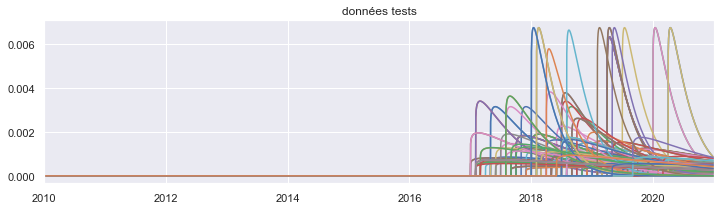

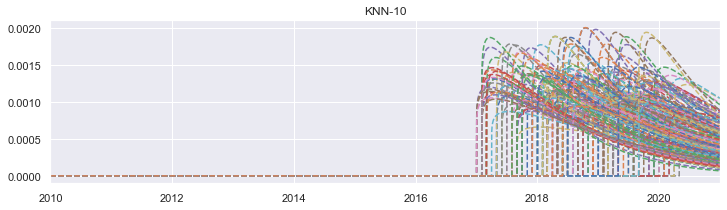

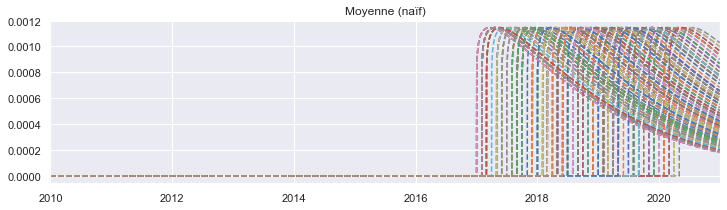

In [88]:
machine_learning_benchmark()